<center>Made by Noah Sarfati</center>

# Optimising IoU Threshold for NMS

In [1]:
# execute this part to modify the css style
from IPython.core.display import HTML
def css_styling():
    styles = open("./style/custom2.css").read()
    return HTML(styles)
css_styling()

<div markdown=1 class="DoIt"> 

Please download in the cocoapi folder `2014 val images` and `2014 val/train annotations` under the names `val2014` and `annotations`

In [1]:
# import the necessary packages

import os
import pathlib
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import json
import random

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.core import post_processing
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile
%matplotlib inline
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

/opt/anaconda3/lib/python3.7/site-packages/object_detection/utils/visualization_utils.py:29: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()

<div markdown=1 class="Prop"> 

First we implement the object detection function with `run_inference_for_single_image` and `show_inference` that will return the desired boxes,classes and scores if the image is in the right format.

In [3]:
#Load object detection model
model_dir = "ssdlite_mobilenet_v2_coco_2018_05_09/saved_model"
detection_model = tf.saved_model.load(str(model_dir))
detection_model = detection_model.signatures['serving_default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [4]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [5]:
def run_inference_for_single_image(model, image):
    
    """
    input:
        model : OD model
        image : np.array format
    output:
        Dictionnary:
            key = ['num_detections','detection_classes','detection_boxes','detection_scores']
    """
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    #If image doesn't respect the right format ignore it
    try:
        output_dict = model(input_tensor)
    except:
        return None

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                  output_dict['detection_masks'], output_dict['detection_boxes'],
                   image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

In [18]:
def show_inference(model, image_path,iou_threshold = 0.6,showImage = False):
    
    """
    input:
    - model: OD model
    - image_path : path of the image you want to study
    - iou_threshold: it is used for the nms that will be applied after the OD
    - showImage: set to true if you want to print the image with the bbox
    
    output:
    A 3D tuple in this order:
    - final_classes : list of int64 telling the category of each detected bbox
    - final_scores : list of float64 scoring each bbox
    - final_boxes : list of coordinates of each bbox (format : [ymin,xmin,ymax,xmax] )
    """
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.array(Image.open(image_path))
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
    if not output_dict : return None,None,None
    # Visualization of the results of a detection.
#     box_selection = post_processing.multiclass_non_max_suppression([output_dict['detection_boxes']], output_dict['detection_scores'], score_thresh=.8, iou_thresh=.5, max_size_per_class=0)
    
    # Apply the nms
    box_selection = tf.image.non_max_suppression_with_scores(
      output_dict['detection_boxes'],output_dict['detection_scores'], 100, iou_threshold= iou_threshold,
      score_threshold=float('-inf'), soft_nms_sigma=0.0, name=None
       )
    
    
    final_boxes = list(box_selection[0].numpy())
    final_scores = list(box_selection[0].numpy())
    final_classes = []
    for i in range(len(final_boxes)):
        index = final_boxes[i]
        final_boxes[i] = output_dict['detection_boxes'][index]
        final_scores[i] = output_dict['detection_scores'][index]
        final_classes.append(output_dict['detection_classes'][index])
    
    #Show the image with bbox
    if showImage:
        vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.array(final_boxes),
          np.array(final_classes),
          np.array(final_scores),
          category_index,
          instance_masks=output_dict.get('detection_masks_reframed', None),
          use_normalized_coordinates=True,
          line_thickness=8)

        display(Image.fromarray(image_np))
    return final_classes,final_scores,final_boxes

<div markdown=1 class="Prop"> 

Load the annotation file. Download `2014 val images` put it in the folder cocoapi and `2014 train/val annotation` in cocoapi/annotations

In [2]:
dataDir='cocoapi/'
dataType='val2014'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [3]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=8.49s)
creating index...
index created!


In [4]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
categories=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(categories)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
electronic vehicle sports food furniture appliance person animal kitchen outdoor indoor accessory


<div markdown=1 class="Prop"> 

For the sake of the experiment we will work for now only on the category person. But very easily I will be able to gather everything to compute all the at the same time.

In [6]:
# get all images containing given categories
catStudied = categories[10]
catIds = coco.getCatIds(catNms=catStudied); #person
imgIds = coco.getImgIds(catIds=catIds);
img = coco.loadImgs(imgIds)
print(len(img))
img = img[:100]

592


In [11]:
from tqdm import tqdm

In [12]:
def putCOCOformat(boxes,im_width,im_height):
    """
    Transform a bbox in the OD format into cocoformat
    input:
        boxes: List of the form [ymin,xmin,ymax,xmax] in the percentage of the image scale
        im_width: real width of the associated image
        im_height: real height of the associated image
    output:
        List of the form [left,top,width,height] describing the bbox, in the image scale
    """
    #float to respect json format
    left = float(boxes[1]) * im_width
    right = float(boxes[3]) * im_width
    top = float(boxes[0]) * im_height
    bottom = float(boxes[2]) * im_height
    width = right - left
    height = bottom - top
    
    return [left,top,width,height]

<div markdown=1 class="Prop"> 

Here we write the res Json file that will be compared to the annotation one in order to compute the AP.

Do I need to write the detected boxes of other classes? For example if I am studying cars and there is a horse that is detected next to it, do I need to write it in the Json?

For now I write every boxes that have been detected

In [13]:
def writeResJson(img,lengthData,iou_threshold = 0.6):
    """
    Write a Json file in the coco annotations format for bbox detections
    
    input:
        img: coco class describing the images to study
        lengthData: The number of image one want to analyse to chose randomly among img
        iou_threshold: Paramaeter for the nms algorithm that will be applied to the OD
    output:
        Json file of the form:
        [{"image_id":42,"category_id":18,"bbox":[258.15,41.29,348.26,243.78],"score":0.236}...]
        The length of this list is lengthData
        
        imgIds: List of the image ids that are studied
    """
    
    PATH = 'cocoapi/val2014/'
    result = []
    imgIds = set() #set to avoid repetition
    imageIter = np.random.choice(range(len(img)),lengthData)
    for i in tqdm(imageIter):

        #[ymin,xmin,ymax,xmax] normalized
        final_classes,final_scores,final_boxes = show_inference(detection_model,PATH+img[i]['file_name'],iou_threshold=iou_threshold)

        if not final_classes: 
            continue
        for j in range(len(final_classes)):
            #ex : {"image_id":42,"category_id":18,"bbox":[258.15,41.29,348.26,243.78],"score":0.236}
            properties = {}

            #json format doesnt support int64
            properties["category_id"] = int(final_classes[j])
            imgId = img[i]["id"]
            properties["image_id"] = imgId
            imgIds.add(imgId)
            im_width = img[i]['width']
            im_height = img[i]['height']

            #we want [ymin,xmin,ymax,xmax] -> [xmin,ymin,width,height]
            properties["bbox"] = putCOCOformat(final_boxes[j],im_width,im_height)
            properties["score"]= float(final_scores[j])

            result.append(properties)
    with open('cocoapi/results/test.json', 'w') as fs:
        json.dump(result, fs, indent=1)
    return list(imgIds)

<div markdown=1 class="Prop"> 

Load res file and define function `getAP05` that will compute the list of AP[iou = 0.5] scores for a number of IoU_threshold between 0.2 and 0.99. (I can easily have the list of every metrics).
I have chosen 0.2 to have as many usefull result as possible. Indeed after a lot of obeservations between 0.1 there wasn't any good score.

Here I have chosen to work on 100 random images among the category at each computation of the metric. The choice of the images is recomputed at every step to be sure to have a result that approximates the reality. I have made this choice because of the time complexity.
It's clear that to have a good computation one would chose all the images and and compute the scores for a lot of iou_thresh. Here I have chosen 50.

Of course the goal is to find an optimal algorithm in order to optimize those computations. But to be honest here we have an irregular problem. Indeed the AP function is different for every categories and is not at all regular. Optimising that kind of function is math field on itself. During the rest of this task I will try to focus on that. The hard method can also be accepted since we don't need to compute the result in live, we just memoize it. We could make it run during 1 day and have the perfect result, that depend on what you prefer? (But not on my computer please :) )

Question related to a previous one: Do I need to compare only boxes of the same category?
i.e do I uncomment `cocoEval.params.catIds  = catIds` ?

In [14]:
resFile = 'cocoapi/results/test.json'

In [ ]:

def getAP05(img,resFile,number_IoU_thresh = 50,numberImgPerComputation=100):
    """
    input:
        img: coco class describing the images to study
        resFile: Json file describing your bbox OD in coco format
        numberImgPerComputation: for each iot iou_threshold, the number of images that will be studied
        to compute the corresponding AP[iou = 0.5]
    output:
        List of AP score associated to the list np.linspace(0.01,0.99,number_IoU_thresh)
    """
    
    iou_thresholdXaxis = np.linspace(0.2,0.99,number_IoU_thresh)
    AP = []
    for iou in iou_thresholdXaxis:
        #Create the Json result file and read it.
        imgIds = writeResJson(img,numberImgPerComputation,iou_threshold=float(iou))
        print(len(imgIds))
        cocoDt=coco.loadRes(resFile)
        # running evaluation
        cocoEval = COCOeval(coco,cocoDt,'bbox')
        cocoEval.params.imgIds  = imgIds
        # cocoEval.params.catIds  = catIds
        cocoEval.evaluate()
        cocoEval.accumulate()
        print("for iou_threshold = {}".format(iou))
        cocoEval.summarize()
        print(cocoEval.stats[1])
        #readDoc and find self.evals
        AP.append(cocoEval.stats[1])
    return AP
    
AP = getAP05(img,resFile,numberImgPerComputation=100)

100%|██████████| 100/100 [00:06<00:00, 15.01it/s]


63
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.19s).
for iou_threshold = 0.2
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.346
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.220
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.316


  2%|▏         | 2/100 [00:00<00:06, 15.50it/s]

 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.044
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.598
0.3815417834293281


100%|██████████| 100/100 [00:06<00:00, 15.15it/s]


62
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


  0%|          | 0/100 [00:00<?, ?it/s]

DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.18s).
for iou_threshold = 0.21612244897959185
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.594
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.252
 Average Reca

 21%|██        | 21/100 [00:01<00:06, 13.00it/s]

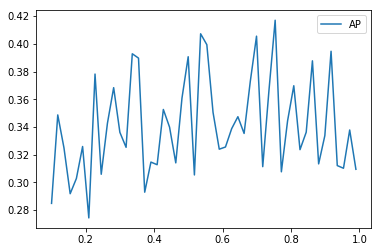

In [17]:
def plotAP(iou,AP):
    # Plot the data
    plt.plot(iou, AP, label='AP')
    # Add a legend
    plt.legend()
    # Show the plot
    plt.show()
plotAP(np.linspace(0.1,0.99,50),AP)
# plotAP(np.linspace(0.1,0.99,30),AP100)
